# Enron Scandal: Indentifying Person of Interest

**Identification of Enron employees who may have committed fraud**

**Supervised Learning. Classification**

Data: [Enron financial dataset from Udacity](https://github.com/udacity/ud120-projects/tree/master/final_project)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")
import helper_ds

helper_ds.set_parent_execution_path()
helper_ds.info_system()
# sns.set_palette("Reds")
helper_ds.reproducible(seed=0)  # setup reproducible results from run to run using Keras

Path changed to /home/angel/DRIVE/0_repos/data-science-keras

HARDWARE:
CPU:	Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
RAM:	15 GB
-- No GPU  --

OS:	Linux-5.15.0-43-generic-x86_64-with-glibc2.35

ENV:	/home/angel/miniconda3/envs/ds-keras

PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
tensorflow                    2.9.1
pandas                        1.4.3
numpy                        1.23.1

EXECUTION PATH: /home/angel/DRIVE/0_repos/data-science-keras
EXECUTION DATE: Sat Aug 13 20:59:49 2022


## 1. Data Processing and Exploratory Data Analysis

###  Load the Data

In [2]:
data_path = "data/enron_financial_data.pkl"
target = ["poi"]

df = pd.read_pickle(data_path)
df = pd.DataFrame.from_dict(df, orient="index")

### Explore the Data

In [3]:
helper_ds.info_data(df, target)

Samples: 	146 
Features: 	20
Target: 	poi
Binary target: 	{False: 128, True: 18}
Ratio 		7.1 : 1.0
Dummy accuracy:	0.88


**Imbalanced target: the evaluation metric used in this problem is the Area Under the ROC Curve** <br>
**poi** =  person of interest (boolean) <br>

In [4]:
df.head(3)

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN


### Transform the data

In [5]:
# delete 'TOTAL' row (at the bottom)
if "TOTAL" in df.index:
    df.drop("TOTAL", axis="index", inplace=True)

# convert dataframe values (objects) to numerical. There are no categorical features
df = df.apply(pd.to_numeric, errors="coerce")

#### Missing features

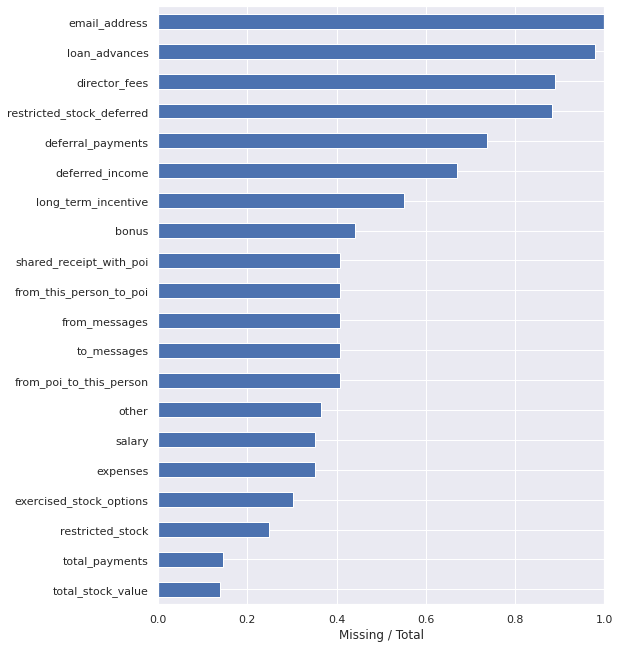

In [6]:
helper_ds.missing(df)

High-missing features, like 'loan_advances', are needed to obtain better models

#### Remove irrelevant features

In [7]:
df.drop("email_address", axis="columns", inplace=True)

#### Classify variables

In [8]:
num = list(df.select_dtypes(include=[np.number]))

df = helper_ds.sort_columns_by_type(df, target, numerical=num)

helper_ds.get_types(df)

19 numerical features: 	 ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
0 categorical features: 	 []
Target: 		poi (bool)


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
Type,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool


#### Fill missing values

In [9]:
# Replace NaN values with the median
df.fillna(df.median(), inplace=True)
# helper_ds.fill_simple(df, target, inplace=True) # same result

### Visualize the data

In [10]:
df.describe(percentiles=[0.5]).astype(int)

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145
mean,275172,1722,383687,2402823,2537413,1002369,-50907,-293981,3040758,51503,52,2455073,377,314211,27,567548,999,972059,104361
std,142866,2029,708602,8785497,6606450,1097889,1305242,575095,6112358,37235,68,4646612,1441,1122664,78,597613,930,1972272,14229
min,477,57,-102500,148,400000,70000,-1787380,-3504386,-44093,148,0,3285,12,2,0,69223,2,-2604490,3285
50%,258741,1211,221063,1100246,2000000,750000,-140264,-151927,1095040,46547,35,1297049,41,51984,8,422158,740,441096,106164
max,1111258,15149,6426990,103559792,81525000,8000000,15456290,-833,49110080,228763,528,34348384,14368,10359729,609,5145434,5521,14761694,137864


#### Numerical features

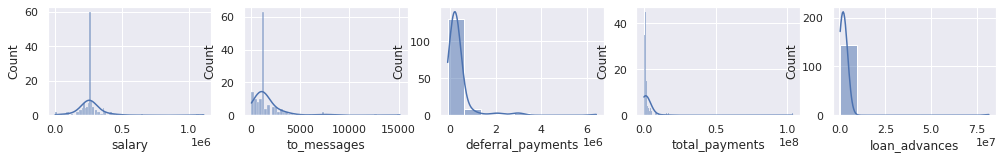

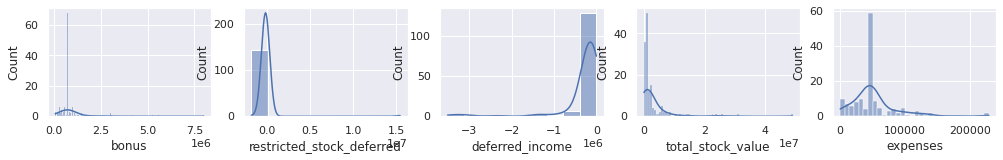

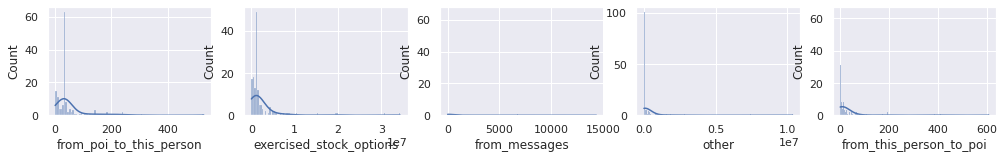

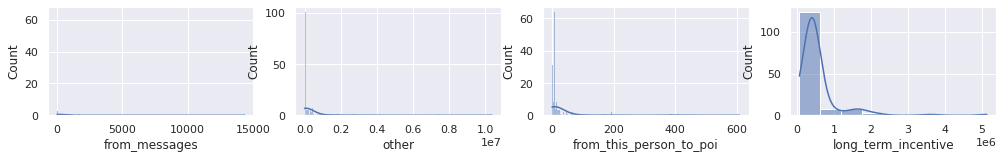

In [11]:
helper_ds.show_numerical(df, kde=True, ncols=5)

#### Target vs Numerical features

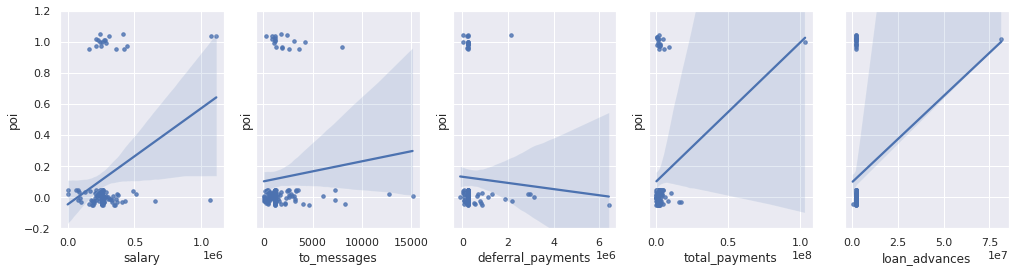

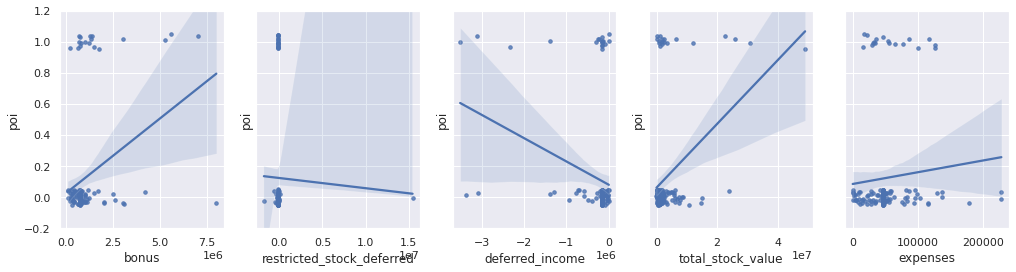

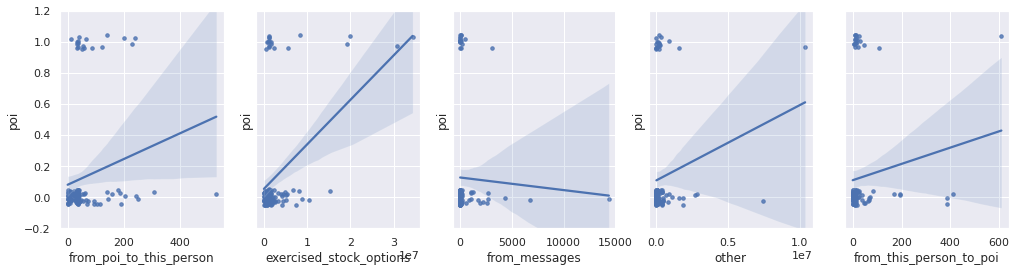

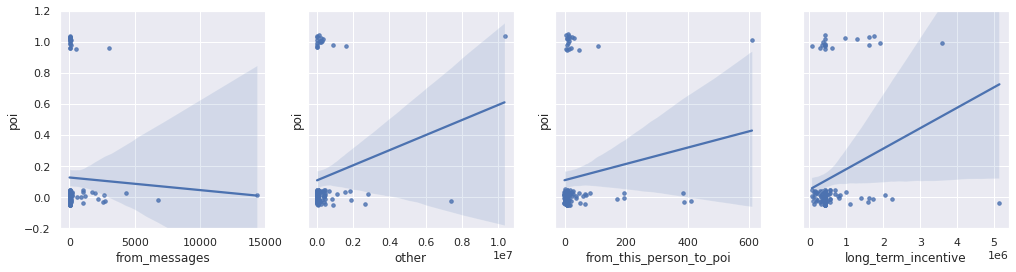

In [12]:
helper_ds.show_target_vs_numerical(df, target, jitter=0.05, point_size=50, ncols=5)

#### Total stock value vs some features 

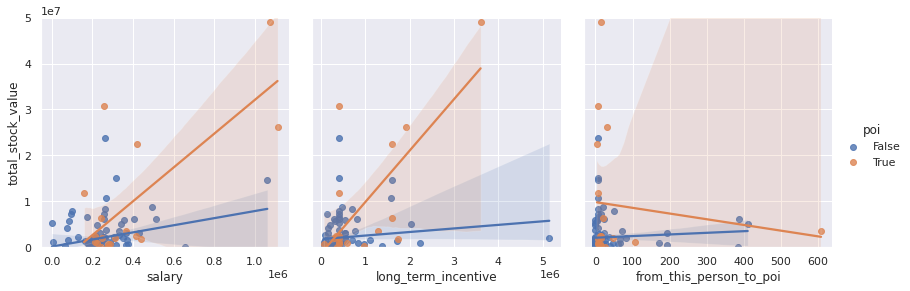

In [13]:
# df.plot.scatter(x='salary', y='total_stock_value')
# df.plot.scatter(x='long_term_incentive', y='total_stock_value')

# sns.lmplot(x="salary", y="total_stock_value", hue='poi', data=df)
# sns.lmplot(x="long_term_incentive", y="total_stock_value", hue='poi', data=df)

g = sns.PairGrid(
    df,
    y_vars=["total_stock_value"],
    x_vars=["salary", "long_term_incentive", "from_this_person_to_poi"],
    hue="poi",
    height=4,
)
g.map(sns.regplot).add_legend()
plt.ylim(ymin=0, ymax=0.5e8);

# sns.pairplot(df, hue='poi', vars=['long_term_incentive', 'total_stock_value', 'from_poi_to_this_person'], kind='reg', size=3)

The person of interest seems to have a higher stock vs salary and long-term incentive, especially when his stock value is high. There is no dependency between POI and the amount of emails from or to another person of interest.

#### Correlation between numerical features and target

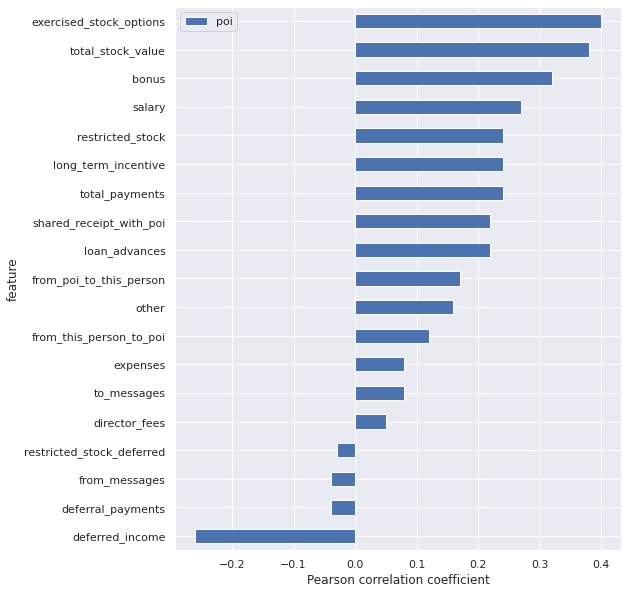

In [14]:
helper_ds.correlation(df, target)

## 2. Neural Network model

### Select the features

In [15]:
droplist = []  # features to drop from the model

# For the model 'data' instead of 'df'
data = df.copy()
data.drop(droplist, axis="columns", inplace=True)
data.head(3)

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
METTS MARK,365788.0,807.0,221063.5,1061827.0,2000000.0,600000.0,-140264.0,-151927.0,585062.0,94299.0,38.0,1297049.0,29.0,1740.0,1.0,422158.0,702.0,585062.0,106164.5,False
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,2000000.0,1200000.0,-140264.0,-1386055.0,10623258.0,11200.0,35.0,6680544.0,41.0,2660303.0,8.0,1586055.0,740.5,3942714.0,106164.5,False
ELLIOTT STEVEN,170941.0,1211.0,221063.5,211725.0,2000000.0,350000.0,-140264.0,-400729.0,6678735.0,78552.0,35.0,4890344.0,41.0,12961.0,8.0,422158.0,740.5,1788391.0,106164.5,False


### Scale numerical features
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [16]:
data, scale_param = helper_ds.scale(data)

There are no categorical variables

### Split the data into training and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

No validation set (small dataset)

In [17]:
test_size = 0.4
random_state = 9

x_train, y_train, x_test, y_test = helper_ds.simple_split(data, target, True, test_size, random_state)

### Encode the output

In [18]:
y_train, y_test = helper_ds.one_hot_output(y_train, y_test)

In [19]:
print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("test size  \t X:{} \t Y:{} ".format(x_test.shape, y_test.shape))

train size 	 X:(87, 19) 	 Y:(87, 2)
test size  	 X:(58, 19) 	 Y:(58, 2) 


### Build a dummy classifier

In [20]:
helper_ds.dummy_clf(x_train, y_train[:, 1], x_test, y_test[:, 1])


Confusion matrix: 
 [[51  0]
 [ 7  0]]


,Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
Dummy,4.17,0.88,0.0,0,0,0


### Build the Neural Network for Binary Classification

In [21]:
# class weight for imbalance target

cw = helper_ds.get_class_weight(y_train[:, 1])

{0: 0.5723684210526315, 1: 3.9545454545454546}


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19)                380       
                                                                 
 dropout (Dropout)           (None, 19)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 40        
                                                                 
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
Training ....
time: 	 1.2 s


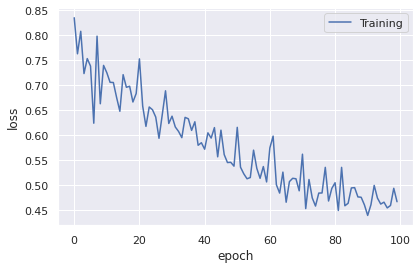


Training loss:  	0.4667

Model saved at models/enron_scandal.h5

ROC_AUC train:	0.92 



In [22]:
model_path = os.path.join("models", "enron_scandal.h5")

model = None
model = helper_ds.build_nn_clf(x_train.shape[1], y_train.shape[1], dropout=0.3, summary=True)

helper_ds.train_nn(model, x_train, y_train, cw=cw, path=model_path)

from sklearn.metrics import roc_auc_score

y_pred_train = model.predict(x_train, verbose=0)
print("\nROC_AUC train:\t{:.2f} \n".format(roc_auc_score(y_train, y_pred_train)))


### Evaluate the model

In [23]:
# Dataset too small for train, validation, and test sets. More data is needed for a proper
y_pred = model.predict(x_test, verbose=0)

helper_ds.binary_classification_scores(y_test[:, 1], y_pred[:, 1], return_dataframe=True, index="DNN")


Confusion matrix: 
 [[36 15]
 [ 1  6]]


,Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
DNN,0.78,0.72,0.29,0.86,0.83,0.43


### Compare with non-neural network models

In [24]:
helper_ds.ml_classification(x_train, y_train[:, 1], x_test, y_test[:, 1])

Naive Bayes
AdaBoost
Random Forest
Extremely Randomized Trees
LGBM


,Time (s),Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
LGBM,0.01,0.34,0.88,0.50,0.29,0.74,0.36
Random Forest,0.10,0.35,0.86,0.33,0.14,0.73,0.20
Extremely Randomized Trees,0.08,0.34,0.84,0.25,0.14,0.74,0.18
AdaBoost,0.06,0.50,0.83,0.29,0.29,0.60,0.29
Naive Bayes,0.00,14.65,0.28,0.11,0.71,0.55,0.19
